In [38]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.9 MB/s eta 0:00:00a 0:00:01


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [75]:
# Step 1: Load and explore the data
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

In [76]:
train_data

,Date,product_code,price,rank,rating,reviews,Qty
0,2020-01-15,0,13.49,49343.250000,NaN,NaN,1
1,2020-01-16,0,12.99,61650.250000,NaN,NaN,0
2,2020-01-17,0,12.99,59805.000000,NaN,NaN,0
3,2020-01-18,0,12.99,69060.333333,NaN,NaN,0
4,2020-01-19,0,12.99,109017.750000,NaN,NaN,0
...,...,...,...,...,...,...,...
8397,2023-03-21,1,26.99,11275.200000,4.1,3466.6,10
8398,2023-03-21,0,NaN,NaN,NaN,NaN,14
8399,2023-03-21,4,37.90,52165.250000,4.7,147.0,6
8400,2023-03-21,5,13.33,14628.000000,4.5,428.0,12


In [77]:
test_data

,Date,product_code,price,rank,rating,reviews
0,2023-03-21,7,22.99,8652.25,4.7,744.875000
1,2023-03-21,3,36.90,37197.00,4.5,1029.000000
2,2023-03-22,0,11.99,8013.50,4.6,434.000000
3,2023-03-22,7,22.99,8449.50,4.7,746.000000
4,2023-03-22,5,13.33,12188.25,4.5,428.000000
...,...,...,...,...,...,...
95,2023-04-02,2,37.90,50721.60,4.9,418.000000
96,2023-04-02,6,19.99,22923.75,4.6,603.000000
97,2023-04-02,1,25.99,11233.00,4.1,3490.666667
98,2023-04-03,0,11.99,6963.60,4.6,439.000000


In [78]:
print("Missing values in train data:")
print(train_data.isna().sum())

print("\nMissing values in test data:")
print(test_data.isna().sum())

Missing values in train data:
Date              0
product_code      0
price           207
rank            207
rating          230
reviews         229
Qty               0
dtype: int64

Missing values in test data:
Date            0
product_code    0
price           0
rank            0
rating          0
reviews         0
dtype: int64


In [79]:
print("Summary statistics for train data:")
print(train_data.describe())

print("\nSummary statistics for test data:")
print(test_data.describe())

Summary statistics for train data:
       product_code        price           rank       rating      reviews  \
count   8402.000000  8195.000000    8195.000000  8172.000000  8173.000000   
mean       3.275054    25.685502   55303.344018     4.499582   507.579441   
std        2.250880     9.651526   66995.764916     0.300469   730.926634   
min        0.000000     7.990000      -1.000000     3.700000     1.000000   
25%        1.000000    14.900000   13252.700000     4.400000    96.000000   
50%        3.000000    24.990000   27106.250000     4.500000   257.000000   
75%        5.000000    35.990000   69356.750000     4.700000   534.000000   
max        7.000000    39.500000  451445.000000     5.000000  3466.600000   

               Qty  
count  8402.000000  
mean      6.507736  
std       6.202491  
min       0.000000  
25%       2.000000  
50%       5.000000  
75%       9.000000  
max     103.000000  

Summary statistics for test data:
       product_code       price          rank  

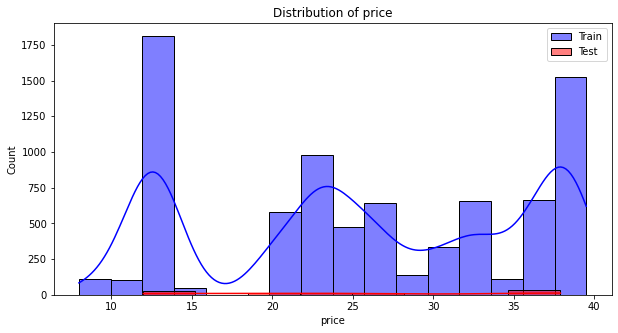

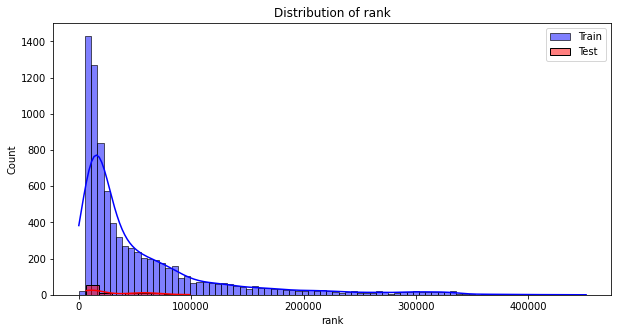

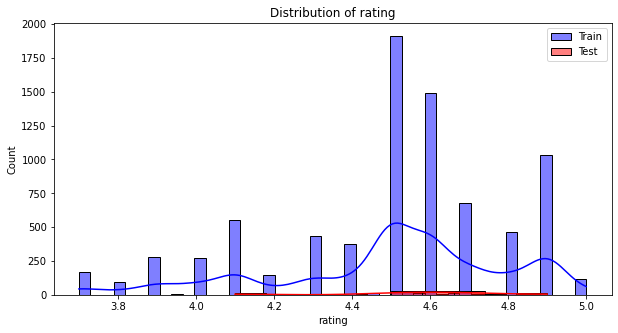

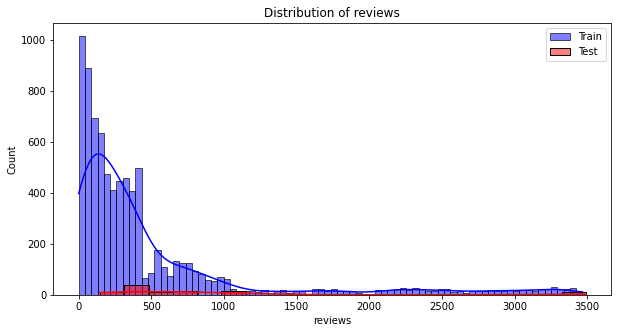

In [83]:
numerical_features = ["price", "rank", "rating", "reviews"]

for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(train_data[feature], kde=True, color="blue", label="Train", alpha=0.5)
    sns.histplot(test_data[feature], kde=True, color="red", label="Test", alpha=0.5)
    plt.legend()
    plt.title(f"Distribution of {feature}")
    plt.show()

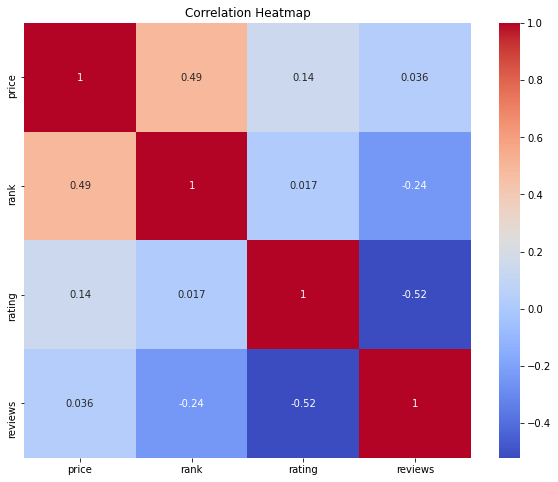

In [84]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_data[numerical_features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

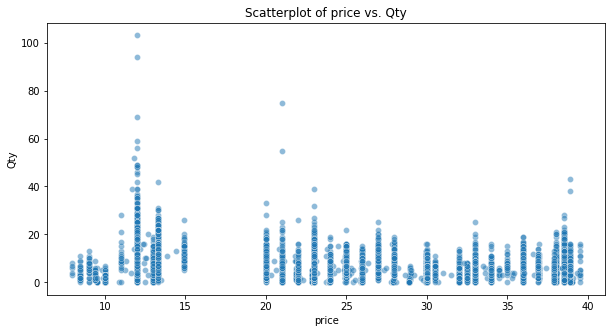

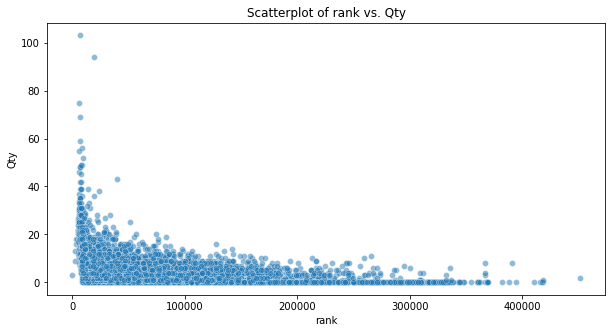

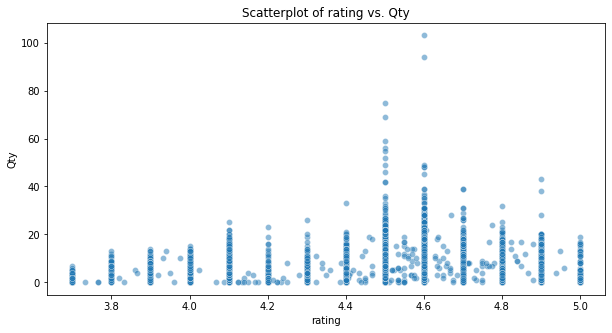

In [85]:
for feature in numerical_features[:-1]:  # Exclude 'Qty' from the features list
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=train_data, x=feature, y="Qty", alpha=0.5)
    plt.title(f"Scatterplot of {feature} vs. Qty")
    plt.show()

In [86]:
# Step 2: Preprocess the data
# Convert date to datetime object and extract features
train_data["Date"] = pd.to_datetime(train_data["Date"])
train_data["Month"] = train_data["Date"].dt.month
train_data["Day"] = train_data["Date"].dt.day
train_data["Year"] = train_data["Date"].dt.year

# Repeat for test_data
test_data["Date"] = pd.to_datetime(test_data["Date"])
test_data["Month"] = test_data["Date"].dt.month
test_data["Day"] = test_data["Date"].dt.day
test_data["Year"] = test_data["Date"].dt.year

# Drop the date column
train_data = train_data.drop("Date", axis=1)
test_data = test_data.drop("Date", axis=1)

In [87]:
# Identify columns with missing values for train_data
missing_cols = train_data.columns[train_data.isna().any()].tolist()

# Impute missing values using the median strategy for both train_data and test_data
imputer = SimpleImputer(strategy="median")
train_data[missing_cols] = imputer.fit_transform(train_data[missing_cols])
test_data[missing_cols] = imputer.transform(test_data[missing_cols])

In [88]:
# Check train_data after preprocessing
train_data

,product_code,price,rank,rating,reviews,Qty,Month,Day,Year
0,0,13.49,49343.250000,4.5,257.0,1,1,15,2020
1,0,12.99,61650.250000,4.5,257.0,0,1,16,2020
2,0,12.99,59805.000000,4.5,257.0,0,1,17,2020
3,0,12.99,69060.333333,4.5,257.0,0,1,18,2020
4,0,12.99,109017.750000,4.5,257.0,0,1,19,2020
...,...,...,...,...,...,...,...,...,...
8397,1,26.99,11275.200000,4.1,3466.6,10,3,21,2023
8398,0,24.99,27106.250000,4.5,257.0,14,3,21,2023
8399,4,37.90,52165.250000,4.7,147.0,6,3,21,2023
8400,5,13.33,14628.000000,4.5,428.0,12,3,21,2023


In [89]:
# Check test_data after preprocessing
test_data

,product_code,price,rank,rating,reviews,Month,Day,Year
0,7,22.99,8652.25,4.7,744.875000,3,21,2023
1,3,36.90,37197.00,4.5,1029.000000,3,21,2023
2,0,11.99,8013.50,4.6,434.000000,3,22,2023
3,7,22.99,8449.50,4.7,746.000000,3,22,2023
4,5,13.33,12188.25,4.5,428.000000,3,22,2023
...,...,...,...,...,...,...,...,...
95,2,37.90,50721.60,4.9,418.000000,4,2,2023
96,6,19.99,22923.75,4.6,603.000000,4,2,2023
97,1,25.99,11233.00,4.1,3490.666667,4,2,2023
98,0,11.99,6963.60,4.6,439.000000,4,3,2023


In [90]:
# Step 3: Split the data into training and validation sets
X = train_data.drop("Qty", axis=1)
y = train_data["Qty"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [91]:
# Step 4: Train and evaluate models
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [92]:
# Train a linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

# Train an XGBoost regression model
model_xgb = XGBRegressor(n_estimators=100, random_state=42)
model_xgb.fit(X_train_scaled, y_train)

# Train a random forest regressor (already included)
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)

# Evaluate the models
models = {"Linear Regression": model_lr, "XGBoost": model_xgb, "Random Forest": model_rf}

for model_name, model in models.items():
    y_pred = model.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred)
    print(f"{model_name} Mean Squared Error: {mse}")

Linear Regression Mean Squared Error: 29.277878206693863
XGBoost Mean Squared Error: 21.00568441297916
Random Forest Mean Squared Error: 20.448471029149314


In [93]:
# Step 5: Optimising the best model (random forest)
# Define the hyperparameter search space
param_dist = {
    "n_estimators": [10, 50, 100, 200, 500],
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": ["auto", "sqrt", "log2"],
}

# Initialize a RandomForestRegressor
base_model = RandomForestRegressor(random_state=42)

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(
    base_model, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1, verbose=2
)

# Fit the randomized search model on the training data
random_search.fit(X_train_scaled, y_train)

# Get the best model found by the randomized search
best_rf_model = random_search.best_estimator_

# Evaluate the best model
y_pred = best_rf_model.predict(X_val_scaled)
mse = mean_squared_error(y_val, y_pred)
print(f"Best Random Forest Model Mean Squared Error: {mse}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Random Forest Model Mean Squared Error: 19.446800635366237


In [94]:
# Step 6: Make predictions on the test_data
# Ensure the 'Qty' column is not present in the test_data DataFrame
if "Qty" in test_data.columns:
    test_data = test_data.drop("Qty", axis=1)

# Scale the test_data
X_test_scaled = scaler.transform(test_data)

# Make predictions using the best_rf_model
y_test_pred = best_rf_model.predict(X_test_scaled)

# Create a new DataFrame with the product_code and the predicted Qty
predictions_df = test_data[["product_code"]].copy()
predictions_df["Qty"] = y_test_pred
predictions_df

,product_code,Qty
0,7,9.733514
1,3,6.901370
2,0,17.684226
3,7,9.807249
4,5,9.344636
...,...,...
95,2,5.407546
96,6,7.968671
97,1,9.891885
98,0,18.844847


In [95]:
# Step 7: Save predictions to a CSV file
predictions_df.to_csv("predictions.csv", index=False)